# Microbiome differential abundance tutorial
This is a jupyter notebook example of how to identify bacteria different between two conditions

## Setup

In [1]:
import calour as ca
ca.set_log_level(11)
%matplotlib notebook
import numpy as np
np.random.seed(2018)

/Users/amnon/miniconda3/envs/calour/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load the data
we use the Chronic faitigue syndrome dataset from

Giloteaux, L., Goodrich, J.K., Walters, W.A., Levine, S.M., Ley, R.E. and Hanson, M.R., 2016.

Reduced diversity and altered composition of the gut microbiome in individuals with myalgic encephalomyelitis/chronic fatigue syndrome.

Microbiome, 4(1), p.30.

In [2]:
cfs=ca.read_amplicon('data/chronic-fatigue-syndrome.biom',
                     'data/chronic-fatigue-syndrome.sample.txt',
                     normalize=10000,min_reads=1000)

2019-04-18 14:07:47 INFO loaded 87 samples, 2129 features
2019-04-18 14:07:47 WARNING These have metadata but do not have data - dropped (1): {'ERR1331814'}
2019-04-18 14:07:47 INFO After filtering, 87 remaining


In [3]:
print(cfs)

AmpliconExperiment ("chronic-fatigue-syndrome.biom") with 87 samples, 2129 features


## Looking at the data

### remove non-interesting bacteria
keep only bacteria with > 10 (normalized) reads total over all samples.

In [4]:
cfs=cfs.filter_abundance(10)

2019-04-18 14:07:49 INFO After filtering, 1100 remaining


### cluster the bacteria
so we'll see how it looks before the differential abundance

In [5]:
cfs=cfs.cluster_features()

2019-04-18 14:07:51 INFO After filtering, 1100 remaining


### sort the samples according to sick/healthy
for the plot. Note this is not required for the differnetial abundance (but doesn't hurt either)

In [6]:
cfs=cfs.sort_samples('Subject')

### plot the original data

<IPython.core.display.Javascript object>


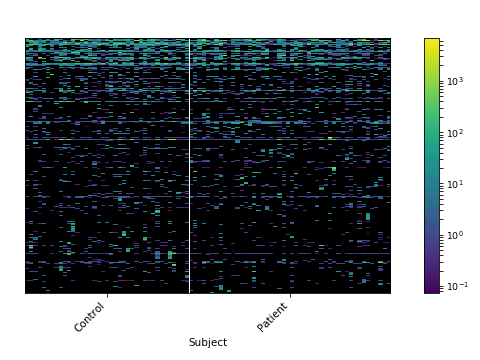

In [7]:
cfs.plot(sample_field='Subject',gui='jupyter')

So we see there are lots of bacteria, hard to see which ones are significantly different between Control (healthy) and Patient (CFS).

## Differential abundance (`diff_abundance`)

### Default options
(rank mean test after rank transform, with [ds-FDR](http://msystems.asm.org/content/2/6/e00092-17) FDR control of 0.1)

Note the results of diff_abundance() is a new Experiment, containing only statistically significant bacteria. The bacteria are sorted according to the effect size (where positive effect size is when group1 > group2, and negative is group1 < group2).

In [8]:
dd=cfs.diff_abundance('Subject','Control','Patient')

2019-04-18 14:08:04 INFO 87 samples with both values
2019-04-18 14:08:04 INFO After filtering, 1100 remaining
2019-04-18 14:08:04 INFO 39 samples with value 1 (['Control'])
2019-04-18 14:08:05 INFO number of higher in Control: 38. number of higher in Patient : 16. total 54


So we got 54 differentially abundant bacteria when we compare all samples that have 'Control' in sample metadata field 'Subject' compared to samples that have 'Patient'

Let's see what we got in a heatmap

<IPython.core.display.Javascript object>


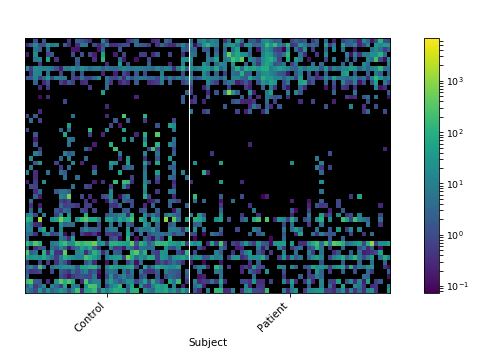

In [9]:
dd.plot(sample_field='Subject',gui='jupyter')

The bacteria at the top are higher (with statistical significance) in 'Patient' compared to 'Control', with the topmost bacteria the most different. 

The bottom bacteria are higher in 'Control' compared to 'Patient', with the bottom-most bacteria the most different.

Note that calour does not show where in the middle is the transition from higher in Control to higher in Patient. This is since we believe if you don't see it by eye, it is not interesting.

However, we can add a colorbar r to indicate the group where the bacteria are higher.

We use the '_calour_direction' field which is added by the diff_abundance() function.

The diff_abundance() also adds the p-value associated with each bacteria ('_calour_pval'), and the effect size('_calour_stat') as fields in the dd.feature_metadata Pandas dataframe

<IPython.core.display.Javascript object>


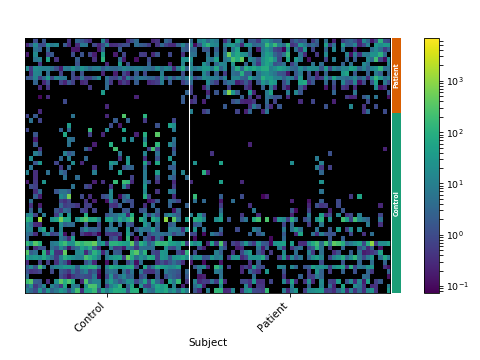

In [11]:
dd.plot(sample_field='Subject',gui='jupyter',bary_fields=['_calour_direction'])

In [12]:
print(dd.feature_metadata.columns)

Index(['_feature_id', 'taxonomy', '_calour_stat', '_calour_pval',
       '_calour_direction'],
      dtype='object')


### Random nature of `diff_abundance`

diff_abundance() calculates the effect size (and p-value) based on random permutations of the sample labels.

Therefore, running diff_abundance() twice may result in slightly different results.
In order to get exactly the same results, we can use the random_seed parameter.

In [13]:
dd=cfs.diff_abundance('Subject','Control','Patient')

2019-04-18 14:10:01 INFO 87 samples with both values
2019-04-18 14:10:01 INFO After filtering, 1100 remaining
2019-04-18 14:10:01 INFO 39 samples with value 1 (['Control'])
2019-04-18 14:10:01 INFO number of higher in Control: 37. number of higher in Patient : 19. total 56


In [14]:
dd2=cfs.diff_abundance('Subject','Control','Patient')

2019-04-18 14:10:05 INFO 87 samples with both values
2019-04-18 14:10:05 INFO After filtering, 1100 remaining
2019-04-18 14:10:05 INFO 39 samples with value 1 (['Control'])
2019-04-18 14:10:05 INFO number of higher in Control: 48. number of higher in Patient : 19. total 67


In [15]:
print('WITHOUT resetting the random seed:')
print('%d different bacteria between the two function calls' % len(set(dd.feature_metadata.index)^set(dd2.feature_metadata.index)))

WITHOUT resetting the random seed:
11 different bacteria between the two function calls


In [16]:
dd=cfs.diff_abundance('Subject','Control','Patient', random_seed=2018)

2019-04-18 14:10:23 INFO 87 samples with both values
2019-04-18 14:10:23 INFO After filtering, 1100 remaining
2019-04-18 14:10:23 INFO 39 samples with value 1 (['Control'])
2019-04-18 14:10:24 INFO number of higher in Control: 38. number of higher in Patient : 16. total 54


In [17]:
dd2=cfs.diff_abundance('Subject','Control','Patient', random_seed=2018)

2019-04-18 14:10:25 INFO 87 samples with both values
2019-04-18 14:10:25 INFO After filtering, 1100 remaining
2019-04-18 14:10:25 INFO 39 samples with value 1 (['Control'])
2019-04-18 14:10:25 INFO number of higher in Control: 38. number of higher in Patient : 16. total 54


In [18]:
print('WITH resetting the random seed:')
print('%d different bacteria between the two function calls' % len(set(dd.feature_metadata.index)^set(dd2.feature_metadata.index)))

WITH resetting the random seed:
0 different bacteria between the two function calls


### Using a different FDR threshold
We can get a larger number of significant bacteria by increasing the FDR threshold (maximal fraction of bacteria which are deemed significant by mistake)

This is done using the `alpha` paramter. Here we allow up to quarter of the results to be due to false rejects.

In [19]:
dd2=cfs.diff_abundance('Subject','Control','Patient', alpha=0.25)

2019-04-18 14:10:30 INFO 87 samples with both values
2019-04-18 14:10:30 INFO After filtering, 1100 remaining
2019-04-18 14:10:30 INFO 39 samples with value 1 (['Control'])
2019-04-18 14:10:31 INFO number of higher in Control: 103. number of higher in Patient : 47. total 150


In [20]:
print('alpha=0.1:\n%s\n\nalpha=0.25\n%s' % (dd, dd2))

alpha=0.1:
AmpliconExperiment ("chronic-fatigue-syndrome.biom") with 87 samples, 54 features

alpha=0.25
AmpliconExperiment ("chronic-fatigue-syndrome.biom") with 87 samples, 150 features


### Using different FDR control methods
Instead of ds-FDR, we can opt for Benjaminy-Hochberg FDR. However, in most cases, it will be more conservative (detect less significant bacteria), due to the discreteness and sparsity of typical microbiome data.

All FDR methods are listed in the diff_abundance API doc.

In [21]:
dd2=cfs.diff_abundance('Subject','Control','Patient', fdr_method='bhfdr', random_seed=2018)

2019-04-18 14:10:36 INFO 87 samples with both values
2019-04-18 14:10:36 INFO After filtering, 1100 remaining
2019-04-18 14:10:36 INFO 39 samples with value 1 (['Control'])
2019-04-18 14:10:36 INFO number of higher in Control: 24. number of higher in Patient : 10. total 34


In [22]:
print('dsFDR:\n%s\n\nBH-FDR\n%s' % (dd, dd2))

dsFDR:
AmpliconExperiment ("chronic-fatigue-syndrome.biom") with 87 samples, 54 features

BH-FDR
AmpliconExperiment ("chronic-fatigue-syndrome.biom") with 87 samples, 34 features


### Using different data normalization before the test
Instead of the default (rank transform), we can use log2 transform (`transform='log2'`), or skip the transformation at all (`transform=None`).

All transform options are listed in the `diff_abundance` API doc.

We recommend using the default rank transform in order to reduce the effect of outliers.

In [23]:
dd2=cfs.diff_abundance('Subject','Control','Patient', transform=None, random_seed=2018)

2019-04-18 14:10:45 INFO 87 samples with both values
2019-04-18 14:10:45 INFO After filtering, 1100 remaining
2019-04-18 14:10:45 INFO 39 samples with value 1 (['Control'])
2019-04-18 14:10:46 INFO number of higher in Control: 20. number of higher in Patient : 5. total 25


In [24]:
print('rankt transform:\n%s\n\nno transform\n%s' % (dd, dd2))

rankt transform:
AmpliconExperiment ("chronic-fatigue-syndrome.biom") with 87 samples, 54 features

no transform
AmpliconExperiment ("chronic-fatigue-syndrome.biom") with 87 samples, 25 features
